In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## 3.12 矢量化加速

In [2]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
        

In [3]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.22128 sec'

In [5]:
#用重载的+运算符
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 3.13 正态分布与平方损失 

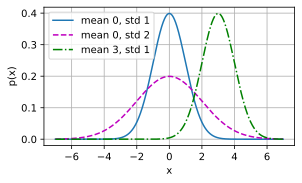

In [6]:
#定义正态分布函数
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p* np.exp(-0.5 / sigma**2 *(x - mu)**2)
#可视化正态分布
x = np.arange(-7, 7, 0.01)

#均值与标准差对
params = [(0,1), (0,2), (3,1)]

d2l.plot(x, [normal(x, mu, sigma) for mu,sigma in params], xlabel='x',
        ylabel='p(x)', figsize=(4.5, 2.5),
        legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 3.2 线性回归的从零开始实现

In [7]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集
$y = Xw + b + \epsilon$


$\epsilon$为模型预测和标签时的潜在观测误差,数据服从标准正态分布假设，真实数据参数 $w = [2,-3.4]^T$ b = 4,2

In [10]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw +b + 噪声"""
    X = torch.normal(0, 1, (num_examples,len(w))) #样本，一行为一个样本，一列为一种特征， 假设服从0，1正态分布
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) #噪声 服从0，0.01正态分布
    return X, y.reshape((-1,1))

features: tensor([-0.6370, -0.7748]) 
label: tensor([5.5734])


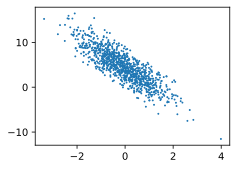

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2 读取数据集 

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #将索引打乱，即样本是随机读取的
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i+ batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [13]:
#读取小批量数据
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

1000
tensor([[-0.5766, -0.4825],
        [ 2.8317, -0.8504],
        [ 1.3751,  0.1612],
        [ 2.1796,  0.0385],
        [-0.4018,  0.9289],
        [ 1.3038, -0.2680],
        [-0.2313,  1.2907],
        [ 2.3723,  0.2139],
        [ 0.1709, -0.5058],
        [-1.0713,  0.1484]]) 
 tensor([[ 4.6703],
        [12.7503],
        [ 6.3957],
        [ 8.4373],
        [ 0.2480],
        [ 7.7148],
        [-0.6700],
        [ 8.2091],
        [ 6.2765],
        [ 1.5684]])


### 3.2.3 初始化模型参数 

In [36]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型 

In [38]:
def linreg(X, w, b): 
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [39]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    """将真实值y的形状转换为和预测值y_hat的形状相同"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法 

In [40]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad(): #不跟踪梯度信息，
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() #将参数的梯度重置为 0，为下一轮的梯度计算做准备。因为 PyTorch 默认会累积梯度，也就是说，每次我们调用 .backward() 方法时，梯度都会被累加在 .grad 属性中，而不是被替换。

### 3.2.7 训练

In [46]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [62]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y) # 小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        # 使用参数的梯度更新参数
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [63]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
